In [1]:
import os
import shutil
from PIL import Image
import matplotlib.pyplot as plt

In [ ]:
label_dir = 'PART_1/PART_1/6categories'
names_path = 'PART_1/PART_1/6categories.names'

# Lê os nomes das classes
with open(names_path, 'r') as f:
    class_names = [line.strip() for line in f if line.strip()]
num_classes = len(class_names)

# Lê as anotações e extrai todos os class_ids usados
used_class_ids = set()

for file in os.listdir(label_dir):
    if file.endswith('.txt'):
        with open(os.path.join(label_dir, file)) as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) == 5:
                    try:
                        class_id = int(parts[0])
                        used_class_ids.add(class_id)
                    except ValueError:
                        continue

# Resultado
print(f"Número de classes em .names: {num_classes}")
print(f"Índices de classe usados nas anotações: {sorted(used_class_ids)}")

# Verifica se estão no intervalo esperado
if max(used_class_ids) >= num_classes:
    print(" Há classes nas anotações fora do intervalo definido no .names.")
else:
    print("Os índices nas anotações estão consistentes com o arquivo .names.")


Número de classes em .names: 6
Índices de classe usados nas anotações: [0, 1, 2, 3, 4, 5]
 Os índices nas anotações estão consistentes com o arquivo .names.


In [3]:
from PIL import Image, UnidentifiedImageError
import os

# Diretórios com imagens
image_dirs = [
    'PART_1/PART_1/images',
    'PART_2/PART_2/images',
    'PART_3/PART_3/images'
]

min_width, min_height = 100, 100
corrompidas = []
pequenas = []

for dir_path in image_dirs:
    for fname in os.listdir(dir_path):
        if not fname.lower().endswith(('.jpg', '.jpeg', '.png')):
            continue
        fpath = os.path.join(dir_path, fname)
        
        # Verifica corrupção
        try:
            with Image.open(fpath) as img:
                img.verify()
        except (UnidentifiedImageError, IOError, SyntaxError):
            corrompidas.append(fpath)
            continue
        
        # Verifica tamanho
        try:
            with Image.open(fpath) as img:
                width, height = img.size
                if width < min_width or height < min_height:
                    pequenas.append((fpath, width, height))
        except:
            continue  # já foi marcada como corrompida

# Resultados
print(f"Imagens corrompidas (outro formato): {len(corrompidas)}")
for path in corrompidas:
    print("CORROMPIDA:", path)

print(f"\nImagens pequenas (<{min_width}x{min_height}): {len(pequenas)}")
for path, w, h in pequenas:
    print(f"PEQUENA: {path} — {w}x{h}")


Imagens corrompidas (outro formato): 0

Imagens pequenas (<100x100): 0


In [4]:
# Diretórios de entrada
part1_dir = 'PART_1/PART_1'
annotation_mode = '6categories'  # ou '2categories'

# Diretório das anotações
label_dir = os.path.join(part1_dir, annotation_mode)

# Diretórios que contêm imagens
image_dirs = [
    'PART_1/PART_1/images',
    'PART_2/PART_2/images',
    'PART_3/PART_3/images'
]

# Diretório de saída
output_dir = f'AFO_CLEAN_{annotation_mode}'
os.makedirs(output_dir, exist_ok=True)

# Conjuntos de dados
splits = ['train', 'validation', 'test']

for split in splits:
    split_txt = os.path.join(part1_dir, f"{split}.txt")

    # Cria as pastas de destino
    split_img_dir = os.path.join(output_dir, split, 'images')
    split_lbl_dir = os.path.join(output_dir, split, 'labels')
    os.makedirs(split_img_dir, exist_ok=True)
    os.makedirs(split_lbl_dir, exist_ok=True)

    # Lê nomes das imagens (.jpg) do split atual
    with open(split_txt, 'r') as f:
        image_names = [line.strip() for line in f if line.strip()]
        #print(len(image_names))

    for name in image_names:
        # Procura a imagem nas três pastas
        img_path = None
        for dir_path in image_dirs:
            candidate_path = os.path.join(dir_path, name)
            if os.path.exists(candidate_path):
                img_path = candidate_path
                #print(img_path)
                break  # achou a imagem, sai do loop

        # Caminho da anotação correspondente (somente PART_1 tem anotações)
        label_name = name.replace('.jpg', '.txt')
        label_path = os.path.join(label_dir, label_name)

        if img_path and os.path.exists(label_path):
            shutil.copy(img_path, os.path.join(split_img_dir, name))
            shutil.copy(label_path, os.path.join(split_lbl_dir, label_name))
        else:
            #continue
            print(f"AVISO: Faltando imagem ou anotação para {name}")
        

In [5]:
import os
import csv

# Diretórios de entrada
part1_dir = 'PART_1/PART_1'
image_dirs = [
    'PART_1/PART_1/images',
    'PART_2/PART_2/images',
    'PART_3/PART_3/images'
]
annotation_dir = os.path.join(part1_dir, '6categories')

# Lê nomes das classes
with open(os.path.join(part1_dir, '6categories.names')) as f:
    classes = [line.strip() for line in f if line.strip()]
num_classes = len(classes)

# Coleta todos os nomes de imagens dos três conjuntos
splits = ['train', 'validation', 'test']
image_names = []
for split in splits:
    split_txt = os.path.join(part1_dir, f"{split}.txt")
    with open(split_txt, 'r') as f:
        image_names += [line.strip() for line in f if line.strip()]
image_names = list(set(image_names))  # remove duplicatas

# Gera o labels.csv
csv_path = 'labels_multilabel.csv'
with open(csv_path, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['filename'] + classes)

    for img_name in image_names:
        label_path = os.path.join(annotation_dir, img_name.replace('.jpg', '.txt'))
        labels_bin = [0] * num_classes

        if os.path.exists(label_path) and os.path.getsize(label_path) > 0:
            with open(label_path, 'r') as f:
                for line in f:
                    if line.strip():
                        class_idx = int(line.strip().split()[0])
                        labels_bin[class_idx] = 1

        writer.writerow([img_name] + labels_bin)

print(f"Arquivo salvo em: {csv_path}")


Arquivo salvo em: labels_multilabel.csv


In [6]:
import pandas as pd
#py -m pip install pandas

csv_path = 'labels_multilabel.csv'
df = pd.read_csv(csv_path)
num_linhas = len(df)

print(f"Número de linhas (imagens): {num_linhas}")

Número de linhas (imagens): 3640


In [7]:
df = pd.read_csv('labels_multilabel.csv')
df.iloc[:, 1:].sum().sort_values(ascending=False)

human             2107
wind/sup-board    1025
kayak              546
boat               339
bouy               177
sailboat           131
dtype: int64

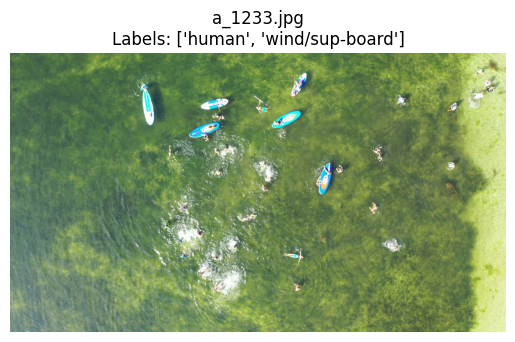

In [8]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

# Caminhos
csv_path = 'labels_multilabel.csv'
image_dirs = [
    'PART_1/PART_1/images',
    'PART_2/PART_2/images',
    'PART_3/PART_3/images'
]

# Carrega o CSV
df = pd.read_csv(csv_path)
classes = df.columns[1:]

# Índice da imagem que você quer visualizar
idx = 90 # <-- altere aqui

# Nome da imagem e vetor de rótulos
row = df.iloc[idx]
img_name = row['filename']
labels = row.values[1:].astype(int)
label_names = [cls for cls, v in zip(classes, labels) if v == 1]

# Localiza a imagem nos diretórios
img_path = None
for d in image_dirs:
    candidate = os.path.join(d, img_name)
    if os.path.exists(candidate):
        img_path = candidate
        break

# Visualiza
if img_path:
    img = Image.open(img_path).convert('RGB')
    plt.imshow(img)
    plt.title(f"{img_name}\nLabels: {label_names}")
    plt.axis('off')
    plt.show()
else:
    print(f"Imagem {img_name} não encontrada em nenhum diretório.")


In [ ]:
import os

# Caminho para os arquivos de anotação (ex: 6categories)
label_dir = 'PART_1/PART_1/6categories'

# Número total de classes (ex: 6 para 6categories.names)
num_classes = 6

# Arquivos .txt de anotação
label_files = [f for f in os.listdir(label_dir) if f.endswith('.txt')]

# Verificação
invalid_annotations = []

for file in label_files:
    path = os.path.join(label_dir, file)
    with open(path, 'r') as f:
        for i, line in enumerate(f, 1):
            parts = line.strip().split()
            if not parts or len(parts) != 5:
                continue  # ignora linhas vazias ou mal formatadas
            try:
                cls_id = int(parts[0])
                if not (0 <= cls_id < num_classes):
                    invalid_annotations.append((file, i, cls_id))
            except ValueError:
                invalid_annotations.append((file, i, parts[0]))

# Resultado
if invalid_annotations:
    print("Classes fora do intervalo encontrado:")
    for fname, line_num, cls in invalid_annotations:
        print(f"Arquivo: {fname}, linha: {line_num}, classe inválida: {cls}")
else:
    print("Nenhuma classe inválida encontrada.")


✅ Nenhuma classe inválida encontrada.


In [10]:
from collections import Counter
names = []
for split in ['train', 'validation', 'test']:
    with open(f'PART_1/PART_1/{split}.txt') as f:
        names += f.read().splitlines()
dups = [item for item, count in Counter(names).items() if count > 1]
print(f"Imagens duplicadas em múltiplos splits: {len(dups)}")


Imagens duplicadas em múltiplos splits: 0
